##Importing Modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
import keras
print(keras.__version__)

3.0.5


##Getting Datasets

In [29]:
from pathlib import Path

data_dir = Path('.\Datasets')
data_dir

<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\D'
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8488\2311721832.py:3: SyntaxWarning: invalid escape sequence '\D'
  data_dir = Path('.\Datasets')


WindowsPath('Datasets')

In [22]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

2158


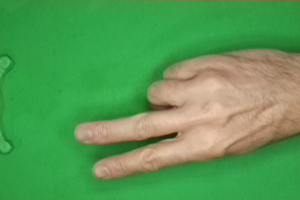

In [30]:
scissors = list(data_dir.glob('scissors/*'))

PIL.Image.open(str(scissors[0]))

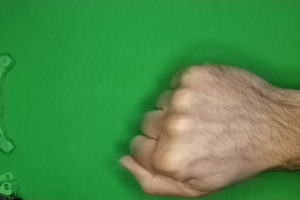

In [25]:
rock = list(data_dir.glob('rock/*'))
PIL.Image.open(str(rock[0]))

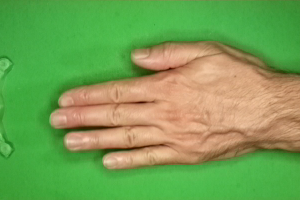

In [26]:
paper = list(data_dir.glob('paper/*'))
PIL.Image.open(str(paper[0]))

##Load data using a Keras utility

In [27]:
batch_size = 32
img_height = 180
img_width = 180

In [31]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2158 files belonging to 3 classes.
Using 1727 files for training.


In [32]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2158 files belonging to 3 classes.
Using 431 files for validation.


In [33]:
class_names = train_ds.class_names
print(class_names)

['paper', 'rock', 'scissors']


##Visualize the Data

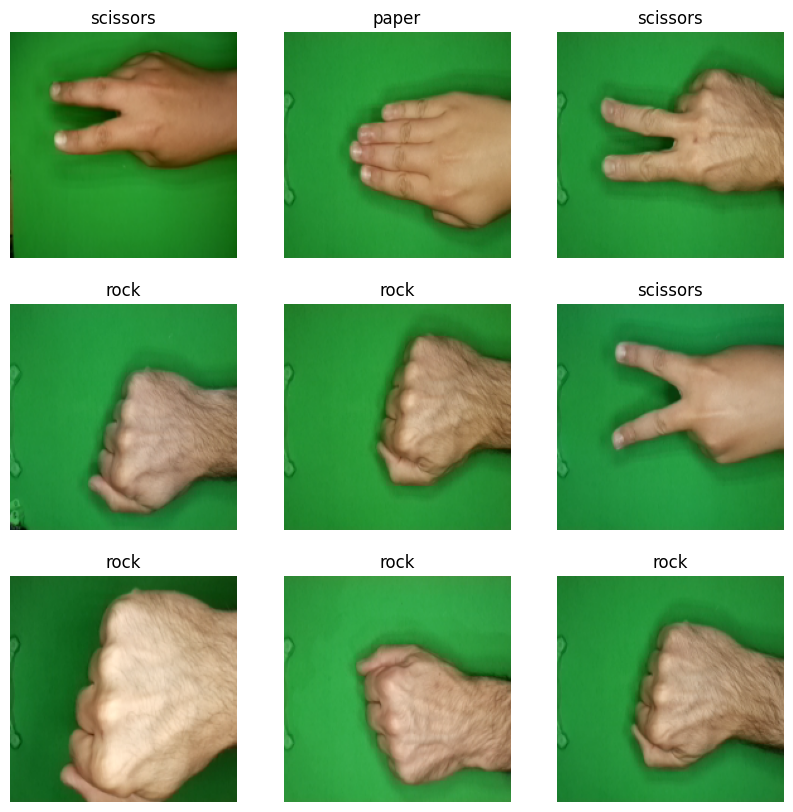

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [35]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


##Configure the dataset for performance

In [36]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

##Standardize the data

In [37]:
normalization_layer = layers.Rescaling(1./255)

In [38]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.96412504


##A basic Keras model

In [39]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


##Compile the model

In [40]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

##Model Summary

In [41]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,027 (15.22 MB)

 Trainable params: 3,989,027 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

##Train the Model

In [42]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/10


54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 185ms/step - accuracy: 0.5254 - loss: 1.2485 - val_accuracy: 0.8144 - val_loss: 0.4857
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.8554 - loss: 0.4208 - val_accuracy: 0.9049 - val_loss: 0.2966
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - accuracy: 0.9275 - loss: 0.2361 - val_accuracy: 0.9258 - val_loss: 0.1899
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - accuracy: 0.9543 - loss: 0.1288 - val_accuracy: 0.9745 - val_loss: 0.0935
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.9828 - loss: 0.0482 - val_accuracy: 0.9722 - val_loss: 0.0969
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - accuracy: 0.9812 - loss: 0.0513 - val_accuracy: 0.9652 - val_loss: 0.1082
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - accuracy: 0.9911 - loss: 0.0226 - val_accuracy: 0.9745 - val_loss: 0.1184
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.9936 - loss: 0.0198 - val_accuracy: 0.9791 - val

##Visualizing training results

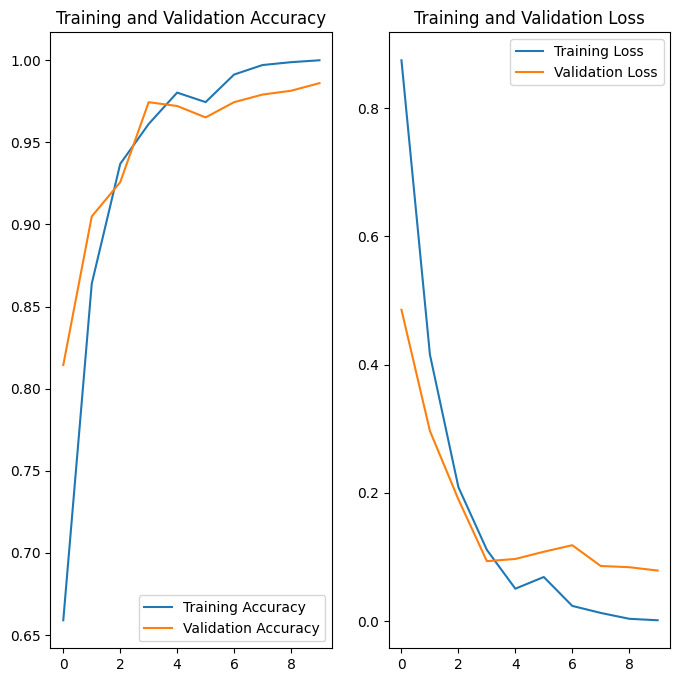

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [45]:
# Test the model on the testing dataset
from sklearn.metrics import confusion_matrix

test_loss, test_accuracy = model.evaluate(val_ds)

print(f'Test Accuracy: {test_accuracy*100:.2f}%')

# Predict labels for the testing set
predicted_labels_probs = model.predict(val_ds)
predicted_labels_classes = np.argmax(predicted_labels_probs, axis=1)

# Convert true labels to numpy array
true_labels = np.concatenate([y for x, y in val_ds], axis=0)

# Print confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report
class_report = classification_report(true_labels, predicted_labels_classes, target_names=class_names)
print("Classification Report:")
print(class_report)

 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9688 - loss: 0.3199

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9803 - loss: 0.1243
Test Accuracy: 98.61%
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Confusion Matrix:
[[140   2   1]
 [  0 149   0]
 [  2   1 136]]
Classification Report:
              precision    recall  f1-score   support

       paper       0.99      0.98      0.98       143
        rock       0.98      1.00      0.99       149
    scissors       0.99      0.98      0.99       139

    accuracy                           0.99       431
   macro avg       0.99      0.99      0.99       431
weighted avg       0.99      0.99      0.99       431



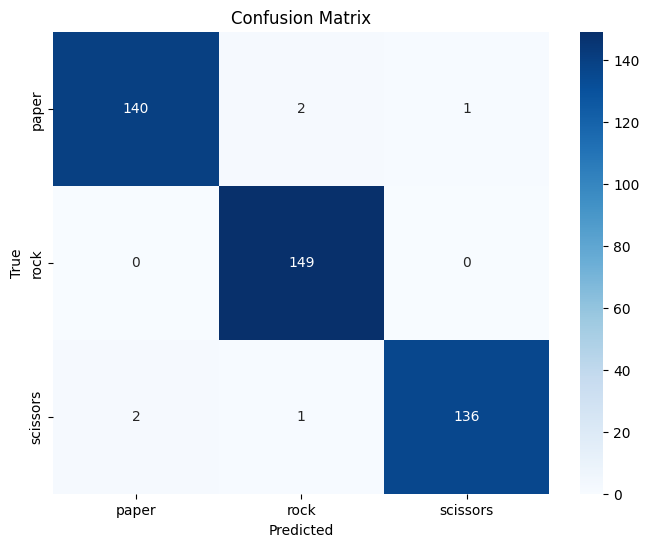

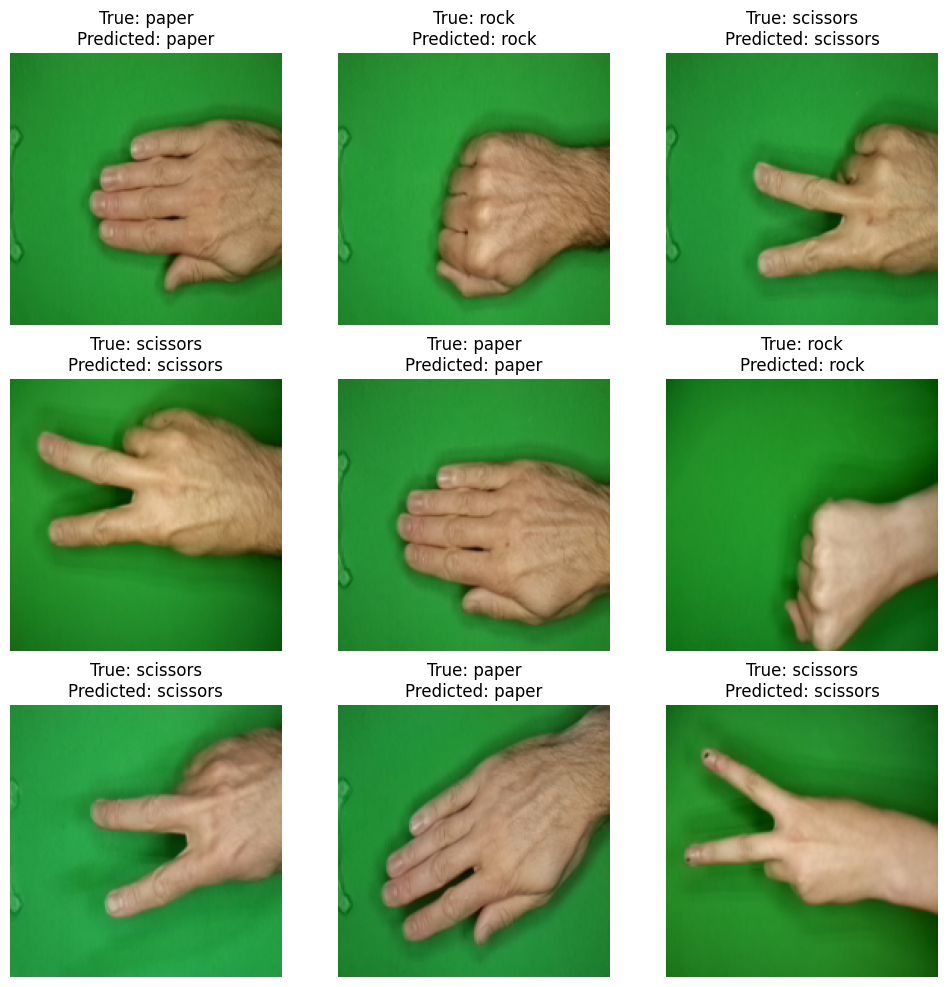

In [49]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Function to visualize the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Visualize the confusion matrix
plot_confusion_matrix(true_labels, predicted_labels_classes, class_names)

# Visualize some sample predictions
plt.figure(figsize=(12, 12))
for images, labels in val_ds.take(1):
    for i in range(min(9, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f'True: {class_names[labels[i]]}\nPredicted: {class_names[predicted_labels_classes[i]]}')
        plt.axis("off")
plt.show()